## Gaussian process Hessian spectra

We consider GP with zero-mean and stationary kernel $k(\vec{x}, \vec{x}') = k(-\frac{1}{2}||\vec{x} - \vec{x}'||_2^2)$. We sample from its Hessian and compute the spectrum, then examining the spectral density and the spectral spacings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from gpytorch import kernels
import torch

In [31]:
def sample_stationary_kernel_hessian(n, kp, kpp, outliers=0, outlier_scale=10, degeneracy=0):
    covar = kp**2 * np.ones((n,n)) + 2 * kpp * np.eye(n)
    diags = np.random.multivariate_normal(np.zeros(n), covar)
    M = np.sqrt(2) * np.sqrt(kpp) * np.random.randn(n, n)
    M = (M + M.T)/2
    M = (M - np.diag(np.diag(M))) + np.diag(diags)
    if degeneracy > 0:
        bottom_panel = np.zeros((degeneracy, n))
        right_panel = np.zeros((degeneracy + n, degeneracy))
        M = np.concatenate([M, bottom_panel], axis=0)
        M = np.concatenate([M, right_panel], axis=1)
    if outliers > 0:
        outlier_evals = (1 + np.random.randn(outliers)**2) * outlier_scale
        outlier_evals = np.concatenate([outlier_evals, np.zeros(M.shape[0] - outliers)])
        np.random.shuffle(outlier_evals)
        M += np.diag(outlier_evals)
    return M

def sample_stationary_kernel_hessian_cond(n, k, kp, kpp, outliers=0, outlier_scale=10, degeneracy=0):
    covar = kp**2 * (1 - 1/k) * np.ones((n,n)) + 2 * kpp * np.eye(n)
    diags = np.random.multivariate_normal(np.zeros(n), covar)
    M = np.sqrt(2) * np.sqrt(kpp) * np.random.randn(n, n)
    M = (M + M.T)/2
    M = (M - np.diag(np.diag(M))) + np.diag(diags)
    if degeneracy > 0:
        bottom_panel = np.zeros((degeneracy, n))
        right_panel = np.zeros((degeneracy + n, degeneracy))
        M = np.concatenate([M, bottom_panel], axis=0)
        M = np.concatenate([M, right_panel], axis=1)
    if outliers > 0:
        outlier_evals = (1 + np.random.randn(outliers)**2) * outlier_scale
        outlier_evals = np.concatenate([outlier_evals, np.zeros(M.shape[0] - outliers)])
        np.random.shuffle(outlier_evals)
        M += np.diag(outlier_evals)
    return M

def sample_eigs(n, kp, kpp, **kwargs):
    M = sample_stationary_kernel_hessian(n, kp, kpp, **kwargs)
    eigs = np.linalg.eigvalsh(M)
    return eigs


def sample_ratios(n, kp, kpp, **kwargs):
    eigs = sample_eigs(n, kp, kpp)
    diffs = eigs[1:] - eigs[:-1]
    return diffs[1:]/diffs[:-1]

def sample_eigs_cond(n, k, kp, kpp, **kwargs):
    M = sample_stationary_kernel_hessian_cond(n, k, kp, kpp, **kwargs)
    eigs = np.linalg.eigvalsh(M)
    return eigs


def sample_ratios_cond(n, k, kp, kpp, **kwargs):
    eigs = sample_eigs_cond(n, k, kp, kpp)
    diffs = eigs[1:] - eigs[:-1]
    return diffs[1:]/diffs[:-1]

In [9]:
def ratio_surmise(r):
    """
    From arXiv:1212.5611
    """
    return 27*((r + r**2)/(1 + r + r**2)**(5/2))/8

We can vary the parameters $k'(0)$ and $k''(0)$ (denoted by `kp` and `kpp` in the code) to give different kernels and different spectral densities. `kp` has little obsevable effect. Larger `kpp` => closer to semi-circle.

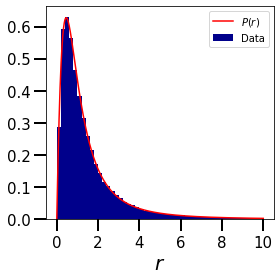

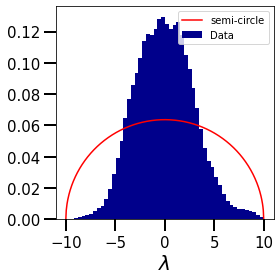

In [26]:
m = 100
n = 300

p=3

kp = p
kpps = p*(p-1)

ratios = np.concatenate([sample_ratios(n, kp, kpp) for _ in range(m)])

plt.figure(figsize=(4,4))
plt.hist(ratios[ratios<10], bins=50, color="darkblue", density=True, label="Data");
x = np.linspace(0, 10, 1000)
plt.plot(x, ratio_surmise(x), c='r' , label="$P(r)$");
plt.xlabel("$r$", fontsize=20)
plt.legend(fontsize=10);
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/spacing_ratios_spinglass.pdf".format(kp, kpp))


plt.figure(figsize=(4,4))

eigs = np.concatenate([sample_eigs(n, kp, kpp) for _ in range(m)])
r = np.max(eigs)
plt.hist(eigs, bins=50, color="darkblue", density=True, label="Data");

def sc(x):
    return np.sqrt(r**2 - x**2)/(np.pi*r**2/2)
x = np.linspace(-r, r, 500)
plt.plot(x, sc(x), c='r', label="semi-circle");
plt.xlabel("$\lambda$", fontsize=20)
plt.legend(fontsize=10, loc='upper right')#,  bbox_to_anchor=(2, 1));
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/density_spinglass.pdf".format(kp, kpp))

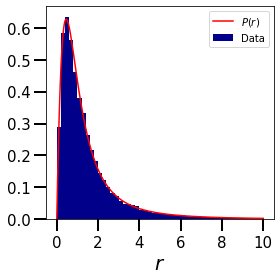

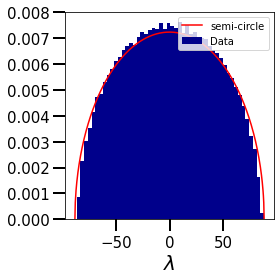

In [32]:
m = 100
n = 300

p=3

k = 1
kp = p
kpp = p*(p-1)

ratios = np.concatenate([sample_ratios_cond(n, k, kp, kpp) for _ in range(m)])

plt.figure(figsize=(4,4))
plt.hist(ratios[ratios<10], bins=50, color="darkblue", density=True, label="Data");
x = np.linspace(0, 10, 1000)
plt.plot(x, ratio_surmise(x), c='r' , label="$P(r)$");
plt.xlabel("$r$", fontsize=20)
plt.legend(fontsize=10);
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/spacing_ratios_spinglass.pdf".format(kp, kpp))


plt.figure(figsize=(4,4))

eigs = np.concatenate([sample_eigs_cond(n, k, kp, kpp) for _ in range(m)])
r = np.max(eigs)
plt.hist(eigs, bins=50, color="darkblue", density=True, label="Data");

def sc(x):
    return np.sqrt(r**2 - x**2)/(np.pi*r**2/2)
x = np.linspace(-r, r, 500)
plt.plot(x, sc(x), c='r', label="semi-circle");
plt.xlabel("$\lambda$", fontsize=20)
plt.legend(fontsize=10, loc='upper right')#,  bbox_to_anchor=(2, 1));
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/density_spinglass.pdf".format(kp, kpp))

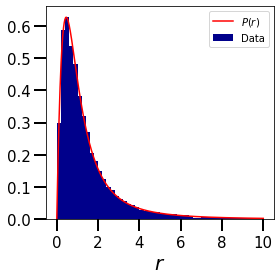

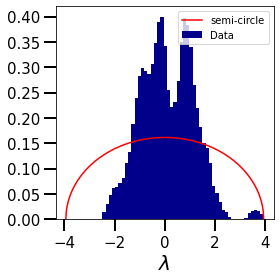

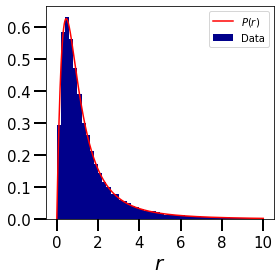

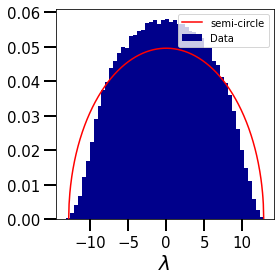

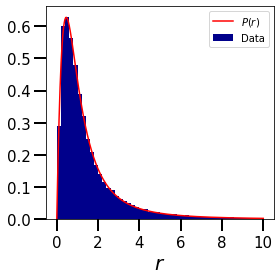

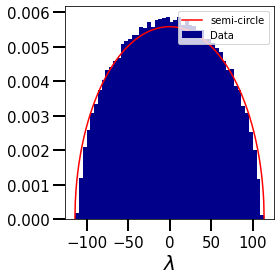

In [28]:
m = 100
n = 300

kp = 1
kpps = [0.0001, 0.1, 10]

for kpp in kpps:
    ratios = np.concatenate([sample_ratios(n, kp, kpp) for _ in range(m)])

    plt.figure(figsize=(4,4))
    plt.hist(ratios[ratios<10], bins=50, color="darkblue", density=True, label="Data");
    x = np.linspace(0, 10, 1000)
    plt.plot(x, ratio_surmise(x), c='r' , label="$P(r)$");
    plt.xlabel("$r$", fontsize=20)
    plt.legend(fontsize=10);
    xticks = plt.xticks(fontsize=15)
    yticks = plt.yticks(fontsize=15)
    ax = plt.gca()
    ax.tick_params(length=12, width=2)
    plt.tight_layout();
    plt.savefig("../figures/gp_kernel/spacing_ratios_kp{}_kpp{}.pdf".format(kp, kpp))


    plt.figure(figsize=(4,4))

    eigs = np.concatenate([sample_eigs(n, kp, kpp) for _ in range(m)])
    r = np.max(eigs)
    plt.hist(eigs, bins=50, color="darkblue", density=True, label="Data");

    def sc(x):
        return np.sqrt(r**2 - x**2)/(np.pi*r**2/2)
    x = np.linspace(-r, r, 500)
    plt.plot(x, sc(x), c='r', label="semi-circle");
    plt.xlabel("$\lambda$", fontsize=20)
    plt.legend(fontsize=10, loc='upper right')#,  bbox_to_anchor=(2, 1));
    xticks = plt.xticks(fontsize=15)
    yticks = plt.yticks(fontsize=15)
    ax = plt.gca()
    ax.tick_params(length=12, width=2)
    plt.tight_layout();
    plt.savefig("../figures/gp_kernel/density_kp{}_kpp{}.pdf".format(kp, kpp))

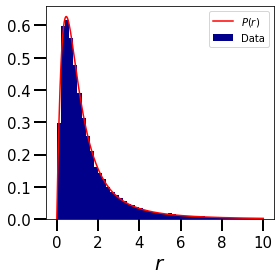

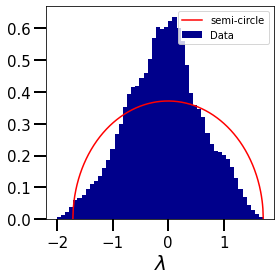

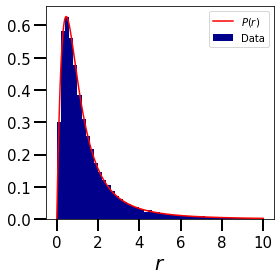

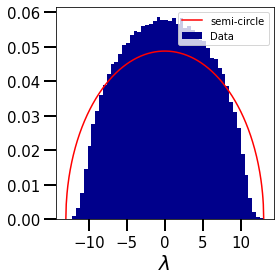

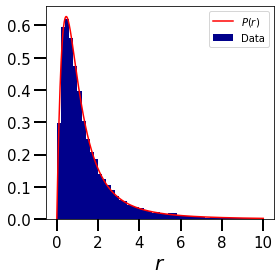

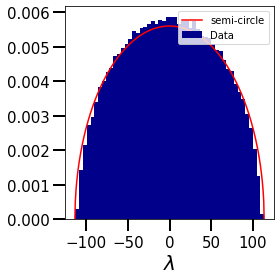

In [33]:
m = 100
n = 300

k=2
kp = 1
kpps = [0.0001, 0.1, 10]

for kpp in kpps:
    ratios = np.concatenate([sample_ratios_cond(n, k, kp, kpp) for _ in range(m)])

    plt.figure(figsize=(4,4))
    plt.hist(ratios[ratios<10], bins=50, color="darkblue", density=True, label="Data");
    x = np.linspace(0, 10, 1000)
    plt.plot(x, ratio_surmise(x), c='r' , label="$P(r)$");
    plt.xlabel("$r$", fontsize=20)
    plt.legend(fontsize=10);
    xticks = plt.xticks(fontsize=15)
    yticks = plt.yticks(fontsize=15)
    ax = plt.gca()
    ax.tick_params(length=12, width=2)
    plt.tight_layout();
    plt.savefig("../figures/gp_kernel/spacing_ratios_cond_k{}_kp{}_kpp{}.pdf".format(k, kp, kpp))


    plt.figure(figsize=(4,4))

    eigs = np.concatenate([sample_eigs_cond(n, k, kp, kpp) for _ in range(m)])
    r = np.max(eigs)
    plt.hist(eigs, bins=50, color="darkblue", density=True, label="Data");

    def sc(x):
        return np.sqrt(r**2 - x**2)/(np.pi*r**2/2)
    x = np.linspace(-r, r, 500)
    plt.plot(x, sc(x), c='r', label="semi-circle");
    plt.xlabel("$\lambda$", fontsize=20)
    plt.legend(fontsize=10, loc='upper right')#,  bbox_to_anchor=(2, 1));
    xticks = plt.xticks(fontsize=15)
    yticks = plt.yticks(fontsize=15)
    ax = plt.gca()
    ax.tick_params(length=12, width=2)
    plt.tight_layout();
    plt.savefig("../figures/gp_kernel/density_cond_k{}_kp{}_kpp{}.pdf".format(k, kp, kpp))

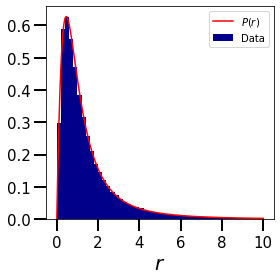

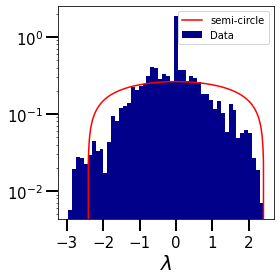

In [14]:
m = 300
n = 500

kp = 1
kpp = 0.001

degeneracy = 100

ratios = np.concatenate([sample_ratios(n, kp, kpp, degeneracy=degeneracy) for _ in range(m)])

plt.figure(figsize=(4,4))
plt.hist(ratios[ratios<10], bins=50, color="darkblue", density=True, label="Data");
x = np.linspace(0, 10, 1000)
plt.plot(x, ratio_surmise(x), c='r' , label="$P(r)$");
plt.xlabel("$r$", fontsize=20)
plt.legend(fontsize=10);
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/spacing_ratios_kp{}_kpp{}_degen{}.pdf".format(kp, kpp, degeneracy))


plt.figure(figsize=(4,4))

eigs = np.concatenate([sample_eigs(n, kp, kpp, degeneracy=degeneracy) for _ in range(m)])
r = np.max(eigs)
plt.hist(eigs, bins=50, color="darkblue", density=True, label="Data");
plt.yscale('log')
def sc(x):
    return np.sqrt(r**2 - x**2)/(np.pi*r**2/2)
x = np.linspace(-r, r, 500)
plt.plot(x, sc(x), c='r', label="semi-circle");
plt.xlabel("$\lambda$", fontsize=20)
plt.legend(fontsize=10, loc='upper right')#,  bbox_to_anchor=(2, 1));
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/density_kp{}_kpp{}_degen{}.pdf".format(kp, kpp, degeneracy))

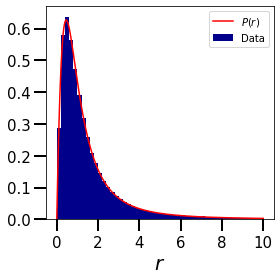

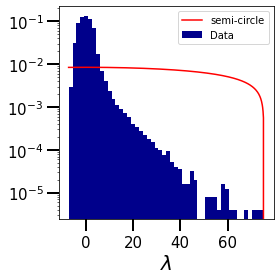

In [15]:
m = 300
n = 500


kp = 1
kpp = 0.1

outliers = 20
outlier_scale = 5

ratios = np.concatenate([sample_ratios(n, kp, kpp, outliers=outliers, outlier_scale=outlier_scale) for _ in range(m)])

plt.figure(figsize=(4,4))
plt.hist(ratios[ratios<10], bins=50, color="darkblue", density=True, label="Data");
x = np.linspace(0, 10, 1000)
plt.plot(x, ratio_surmise(x), c='r' , label="$P(r)$");
plt.xlabel("$r$", fontsize=20)
plt.legend(fontsize=10);
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/spacing_ratios_kp{}_kpp{}_outlier{}.pdf".format(kp, kpp, outliers))


plt.figure(figsize=(4,4))

eigs = np.concatenate([sample_eigs(n, kp, kpp, outliers=outliers, outlier_scale=outlier_scale) for _ in range(m)])
r = np.max(eigs)
plt.hist(eigs, bins=50, color="darkblue", density=True, label="Data");
plt.yscale('log')
def sc(x):
    return np.sqrt(r**2 - x**2)/(np.pi*r**2/2)
x = np.linspace(np.min(eigs), r, 500)
plt.plot(x, sc(x), c='r', label="semi-circle");
plt.xlabel("$\lambda$", fontsize=20)
plt.legend(fontsize=10, loc='upper right')#,  bbox_to_anchor=(2, 1));
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/density_kp{}_kpp{}_outlier{}.pdf".format(kp, kpp, outliers))

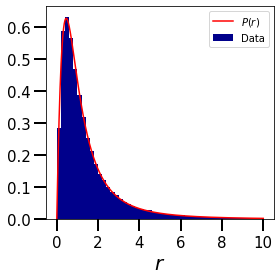

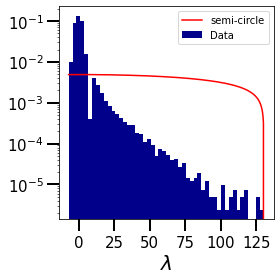

In [16]:
m = 300
n = 500


kp = 1
kpp = 0.1

outliers = 20
outlier_scale = 10

ratios = np.concatenate([sample_ratios(n, kp, kpp, outliers=outliers, outlier_scale=outlier_scale) for _ in range(m)])

plt.figure(figsize=(4,4))
plt.hist(ratios[ratios<10], bins=50, color="darkblue", density=True, label="Data");
x = np.linspace(0, 10, 1000)
plt.plot(x, ratio_surmise(x), c='r' , label="$P(r)$");
plt.xlabel("$r$", fontsize=20)
plt.legend(fontsize=10);
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/spacing_ratios_kp{}_kpp{}_outlier{}.pdf".format(kp, kpp, outliers))


plt.figure(figsize=(4,4))

eigs = np.concatenate([sample_eigs(n, kp, kpp, outliers=outliers, outlier_scale=outlier_scale) for _ in range(m)])
r = np.max(eigs)
plt.hist(eigs, bins=50, color="darkblue", density=True, label="Data");
plt.yscale('log')
def sc(x):
    return np.sqrt(r**2 - x**2)/(np.pi*r**2/2)
x = np.linspace(np.min(eigs), r, 500)
plt.plot(x, sc(x), c='r', label="semi-circle");
plt.xlabel("$\lambda$", fontsize=20)
plt.legend(fontsize=10, loc='upper right')#,  bbox_to_anchor=(2, 1));
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/density_kp{}_kpp{}_outlier{}.pdf".format(kp, kpp, outliers))

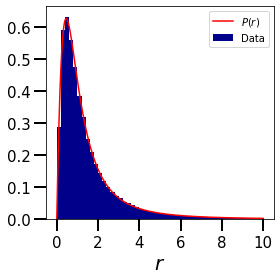

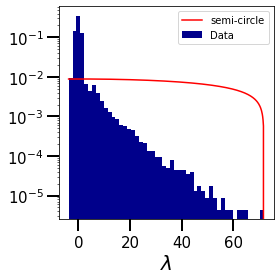

In [17]:
m = 300
n = 500


kp = 1
kpp = 0.01

outliers = 20
outlier_scale = 5

ratios = np.concatenate([sample_ratios(n, kp, kpp, outliers=outliers, outlier_scale=outlier_scale) for _ in range(m)])

plt.figure(figsize=(4,4))
plt.hist(ratios[ratios<10], bins=50, color="darkblue", density=True, label="Data");
x = np.linspace(0, 10, 1000)
plt.plot(x, ratio_surmise(x), c='r' , label="$P(r)$");
plt.xlabel("$r$", fontsize=20)
plt.legend(fontsize=10);
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/spacing_ratios_kp{}_kpp{}_outlier{}.pdf".format(kp, kpp, outliers))


plt.figure(figsize=(4,4))

eigs = np.concatenate([sample_eigs(n, kp, kpp, outliers=outliers, outlier_scale=outlier_scale) for _ in range(m)])
r = np.max(eigs)
plt.hist(eigs, bins=50, color="darkblue", density=True, label="Data");
plt.yscale('log')
def sc(x):
    return np.sqrt(r**2 - x**2)/(np.pi*r**2/2)
x = np.linspace(np.min(eigs), r, 500)
plt.plot(x, sc(x), c='r', label="semi-circle");
plt.xlabel("$\lambda$", fontsize=20)
plt.legend(fontsize=10, loc='upper right')#,  bbox_to_anchor=(2, 1));
xticks = plt.xticks(fontsize=15)
yticks = plt.yticks(fontsize=15)
ax = plt.gca()
ax.tick_params(length=12, width=2)
plt.tight_layout();
plt.savefig("../figures/gp_kernel/density_kp{}_kpp{}_outlier{}.pdf".format(kp, kpp, outliers))